<a href="https://colab.research.google.com/github/eispoohw/CS493-Math-Methods-in-ML/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 5.1

Набор данных тут: https://github.com/sismetanin/rureviews, также есть в папке [Data](https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L). Те, кто предпочитает работать с английским языком, могут использовать набор данных `sms_spam`.

Применим полученные навыки и решим задачу анализа тональности отзывов. 

Нужно повторить весь пайплайн от сырых текстов до получения обученной модели.

Обязательные шаги предобработки:
1. токенизация
2. приведение к нижнему регистру
3. удаление стоп-слов
4. лемматизация
5. векторизация (с настройкой гиперпараметров)
6. построение модели
7. оценка качества модели

Обязательно использование векторайзеров:
1. мешок n-грамм (диапазон для n подбирайте самостоятельно, запрещено использовать только униграммы).
2. tf-idf ((диапазон для n подбирайте самостоятельно, также нужно подбирать гиперпараметры max_df, min_df, max_features)
3. символьные n-граммы (диапазон для n подбирайте самостоятельно)

В качестве классификатора нужно использовать наивный байесовский классификатор. 

Для сравнения векторайзеров между собой используйте precision, recall, f1-score и accuracy. Для этого сформируйте датафрейм, в котором в строках будут разные векторайзеры, а в столбцах разные метрики качества, а в  ячейках будут значения этих метрик для соответсвующих векторайзеров.

In [1]:
import pandas as pd
import numpy as np

!gdown 1IKfQNbkGADSFUdyPdVjQS-ucFhOiT6sM

Downloading...
From: https://drive.google.com/uc?id=1IKfQNbkGADSFUdyPdVjQS-ucFhOiT6sM
To: /content/sms_spam.csv
100% 481k/481k [00:00<00:00, 130MB/s]


In [2]:
from sklearn.metrics import * 
from sklearn.model_selection import train_test_split

df = pd.read_csv('sms_spam.csv')
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['type'])

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def preprocessing(text: str) -> str:
    return ' '.join([lemmatizer.lemmatize(t) for t in word_tokenize(text.lower()) if lemmatizer.lemmatize(t) not in stopwords.words('english')])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

ngram = CountVectorizer(
    ngram_range=(1, 3), 
    preprocessor=preprocessing,
    max_df=0.3,
    min_df=0.001,
    max_features=2000
)

tfidf = TfidfVectorizer(
    ngram_range=(1, 1), 
    preprocessor=preprocessing,
    max_df=0.2,
    min_df=0.0001,
    max_features=1000
)

chargram = CountVectorizer(
    ngram_range=(3, 3), 
    analyzer='char',
    preprocessor=preprocessing,
    max_df=0.4,
    min_df=0.0001,
    max_features=2000
)

vectorizers = {
    'мешок n-грамм': ngram,
    'tf-idf': tfidf,
    'символьные n-граммы': chargram
}

In [5]:
clf = MultinomialNB()

metriks = pd.DataFrame()

for v in vectorizers:
    train = vectorizers[v].fit_transform(X_train)
    clf.fit(train, y_train)
    pred = clf.predict(vectorizers[v].transform(X_test))
    m = precision_recall_fscore_support(y_test, pred, average='weighted')
    metriks = metriks.append({'vectorizer': v, 'precision': m[0], 'recall': m[1], 'fscore': m[2], 'accuracy': accuracy_score(y_test, pred)}, ignore_index=True)

metriks.set_index(['vectorizer'])

,precision,recall,fscore,accuracy
vectorizer,,,,
мешок n-грамм,0.981095,0.981295,0.981090,0.981295
tf-idf,0.977519,0.977698,0.977221,0.977698
символьные n-граммы,0.976555,0.976259,0.976383,0.976259


## Задание 5.2 Регулярные выражения

Регулярные выражения - способ поиска и анализа строк. Например, можно понять, какие даты в наборе строк представлены в формате DD/MM/YYYY, а какие - в других форматах. 

Или бывает, например, что перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

Для работы с регулярными выражениями есть библиотека **re**

In [6]:
import re

В регулярных выражениях, кроме привычных символов-букв, есть специальные символы:
* **?а** - ноль или один символ **а**
* **+а** - один или более символов **а**
* **\*а** - ноль или более символов **а** (не путать с +)
* **.** - любое количество любого символа

Пример:
Выражению \*a?b. соответствуют последовательности a, ab, abc, aa, aac НО НЕ abb!

Рассмотрим подробно несколько наиболее полезных функций:

### findall
возвращает список всех найденных непересекающихся совпадений.

Регулярное выражение **ab+c.**: 
* **a** - просто символ **a**
* **b+** - один или более символов **b**
* **c** - просто символ **c**
* **.** - любой символ


In [7]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc') 
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

*- Так как возвращаются все непересекающиеся значения, для abcx нет свободного символа a*

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

In [8]:
pattern = r'\b[a-zA-Z]{2}'
row = 'abcd e f5ghk  lm nop q'
result = re.findall(pattern, row)
result

['ab', 'lm', 'no']

### split
разделяет строку по заданному шаблону


In [9]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [10]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit=2) 
print(result)

['itsy', ' bitsy', ' teenie, weenie']


**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [11]:
row = 'One two, three. Four five! Six se-ven. Eight. Nine. Ten.'
result = re.split('\.[^\b]', row, maxsplit=2)
result

['One two, three', 'Four five! Six se-ven', 'Eight. Nine. Ten.']

### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [12]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


**Задание**: напишите регулярное выражение, которое позволит заменить все цифры в строке на "DIG".

In [13]:
row = "123 4 5abra 6cadabra7 8910"
result = re.sub('\d+', 'DIG', row)
result

'DIG DIG DIGabra DIGcadabraDIG DIG'

**Задание**: напишите  регулярное выражение, которое позволит убрать url из строки.

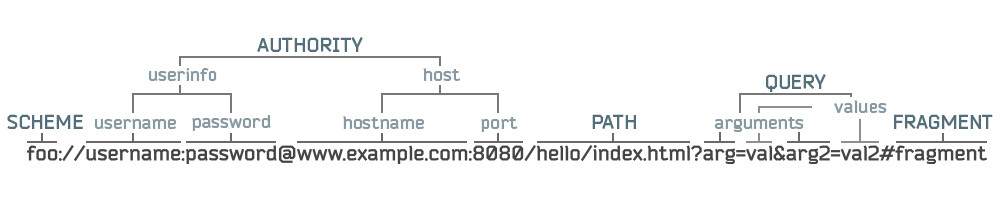

In [14]:
# Source: https://habr.com/ru/post/232385/  
# не используется userinfo и fragment, так как пароль могут содержать любые символы

row = "piazza.com/class https://leetcode.com/problemset/all/?difficulty=HARDpage=1 _ww3.example.com/index.html localhost:9999/"

scheme = r"([A-Za-z][\w+.-]+:)?"

domain = r"[A-Za-z0-9][\w-]*\w"
port = "(:[0-9]{1,5})?"
host = f"((({domain}\.)+{domain})|localhost){port}"

path = r"(/[!$&'()*+,;=%-\._~:@\w]+)*"
query = r"[?]([\w%]+=[\w%]*)(&[\w%]+=[\w%]*)*&?"

pattern = f"\\b{scheme}(//)?{host}{path}/?({query})?"

result = re.sub(pattern, 'url', row, )
result

'url url=1 _ww3.url url'

### compile
компилирует регулярное выражение в отдельный объект

In [15]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

In [16]:
row = "Слова? Да, больше, ещё больше слов! Что-то ещё."
prog = re.compile('[А-Яа-яё-]{4,}')
prog.findall(row)

['Слова', 'больше', 'больше', 'слов', 'Что-то']

**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

In [17]:
row = "abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz"
prog = re.compile(r'(?<=@)(\w[\w-]*\w(?:\.\w[\w-]*\w)*)\b')
prog.findall(row)

['gmail.com', 'test.in', 'analyticsvidhya.com', 'rest.biz']